In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Updating final reports for CEC'2015

First, using the webpage [pdftables](https://pdftables.com/) the PDF tables are translate to Excel format. 

- First, we have put all results in a Excel file.

- Then, we are going to use the pandas library to read the data.

In [2]:
import pandas as pd

In [3]:
table_alg =pd.ExcelFile("results_cec2015.pdf.xlsx")

Then, we read the Sheet right (the 2 in the example)

In [4]:
print(table_alg.sheet_names)
df=table_alg.parse(table_alg.sheet_names[1])

['DECC-G', 'DEEPSO', 'DEEPSO_orig', 'SACC', 'MOS', 'VMODE', 'IHDELS', 'IHDELS_orig', 'CC-CMA-ES', 'CC-CMA-ES_orig']


In [5]:
print(df)

            1.2e5           6e5           3e6
f01  2.990000e+10  4.610000e+09  1.440000e+08
f02  3.450000e+04  2.610000e+04  1.490000e+04
f03  2.120000e+01  2.090000e+01  2.040000e+01
f04  4.270000e+11  4.950000e+10  4.770000e+09
f05  1.560000e+07  1.460000e+07  1.450000e+07
f06  1.050000e+06  1.040000e+06  1.020000e+06
f07  3.500000e+09  2.400000e+08  1.540000e+07
f08  8.330000e+14  1.680000e+14  5.420000e+12
f09  1.030000e+09  9.290000e+09  9.170000e+08
f10  9.410000e+07  9.220000e+07  9.070000e+07
f11  7.520000e+11  8.030000e+09  5.600000e+08
f12  7.800000e+11  1.550000e+11  1.540000e+10
f13  1.820000e+11  1.290000e+10  8.750000e+08
f14  2.180000e+12  1.630000e+11  4.330000e+08
f15  6.600000e+12  3.000000e+07  7.040000e+06


I need a function that get the right position of the Data Frame, considering the function number and the accuracy level.

In [6]:
def get_best_pos(function, accuracy_level=0):
    """
    This function get the final position from the function and the accurary_level required (0 = 1.2e5, 1=6e5, 2=3e6)
    
    Keyword arguments:
    function -- function.
    accuracy_level -- level of accuracy (0 to 2)
    """
    f = function - 1
    r = (f % 5)
    c = (f / 5)*16+accuracy_level*5
    return r+1, c

In [7]:
for f in range(1, 16):
    print(f, get_best_pos(f))

1 (1, 0.0)
2 (2, 3.2)
3 (3, 6.4)
4 (4, 9.6)
5 (5, 12.8)
6 (1, 16.0)
7 (2, 19.2)
8 (3, 22.4)
9 (4, 25.6)
10 (5, 28.8)
11 (1, 32.0)
12 (2, 35.2)
13 (3, 38.4)
14 (4, 41.6)
15 (5, 44.8)


In [8]:
def parse_table_orig(df):
    accuracies = ['1.2e5', '6e5', '3e6']
    best = pd.DataFrame(columns=accuracies)

    for acc_index, acc in enumerate(accuracies):
        val = []
        for f in range(1,16):
            r, c = get_best_pos(f, acc_index)
            val.append(df['f {}'.format(r)][c])
        best[acc] = val
    best.index = ['f{:02d}'.format(i+1) for i in range(15)]
    return best

In [9]:
df=table_alg.parse(table_alg.sheet_names[1])

### Get all the data for comparisons

In [10]:
df = {}

for alg in table_alg.sheet_names:
    df[alg]=table_alg.parse(alg)
    
#    if "_orig" in alg:
#        df[alg] = parse_table_orig(df[alg])

## Get function that calculate the points for function

In [11]:
def calculate_points(fun, dfs, algs, acc=0):
    """
    Returns the ranking in positions for the function and algorithm desired. 
    
    Keyword parameters: 
    - fun -- function to compare.
    - dfs -- hash with the dataframes for algorithm.
    - algs -- algorithms to compare (must be into df). 
    - acc -- accuracy level (from 0 to 2).
    """
    values = pd.DataFrame(columns=algs)
    
    for alg in algs:
        df = dfs[alg]
        values[alg] = [df[acc][fun-1]]

    ranks = values.rank(1, method='min')
    return np.array(ranks, dtype=np.int).reshape(len(algs))

The following function return the scores for each position following the Formula 1 criterion.

In [12]:
def get_f1_score(num_algs):
    """
    Return a np.array with the scoring criterio by position from the Formula 1, in which
    the first 10 items have scores. 
    The array have num_algs positions. 
    
    - If num_algs is lower than 10, it is shorten. 
    - If num_algs is greater than 10, it is increased with 0s. 
    """
    f1 = np.array([25, 18, 15, 12, 10, 8, 6, 4, 2, 1])
    
    if len(algs) < len(f1):
        f1 = f1[:len(algs)]
    else:
        f1 += np.zeros(len(algs))

    return f1

Finally, a function get_scores combine the previous two functions.

In [13]:
def get_scores(df, algs, funs, accuracies):
    """
    This function returns the scores for the algs 'algs', functions 'funs' and accuracies 'accuracies'.
    
    Keyword parameters:
    df -- dataframe with the data.
    algs -- algorithms to compare (must be included in df). 
    funs -- functions to compare.
    accuracies -- accuracy levels to compare (in string).
    """
    size = len(algs)
    f1 = get_f1_score(size)
    result = np.zeros(size)

    for acc in accuracies:
        for i in funs:
            result += f1[calculate_points(i, df, algs, acc)-1]
    
    results_alg = {alg: res for alg, res in zip(algs, result)}
    return results_alg


## Putting all together

Init the initial parameters.

In [14]:
algs = filter(lambda x: not "_orig" in x, df.keys())

algs = filter(lambda x: not "_old" in x, algs)
algs = [alg for alg in algs]
print(algs)
#algs = ['IHDELS', 'MOS']
accuracies = ['1.2e5', '6e5', '3e6']
funs_group = [range(1, 4), range(4, 8), range(8, 12), range(12, 15), [15]]
funs_group_names = ['Fully Separable', 'Partially Separable I', 'Partially Separable II', 'Overlapping', 'Non-separable']

['DECC-G', 'MOS', 'VMODE', 'SACC', 'IHDELS', 'CC-CMA-ES', 'DEEPSO']


Now, we prepare the library.

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
# Increase font
sns.set(font_scale=1.5)
# Put white grid
sns.set_style("whitegrid")

### First, Comparing by group of variables

#### It is very simple

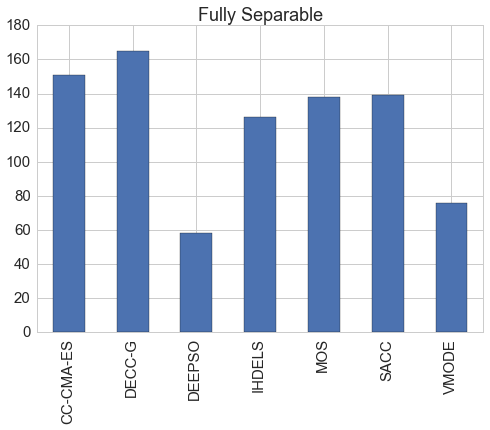

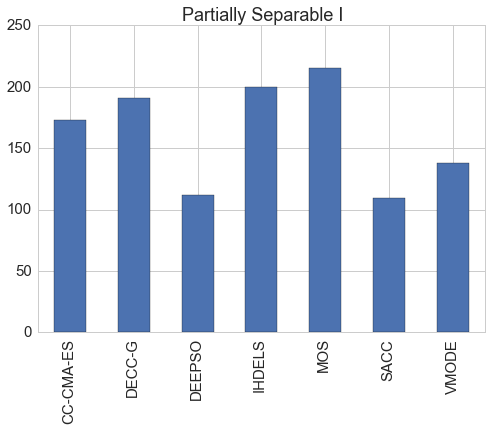

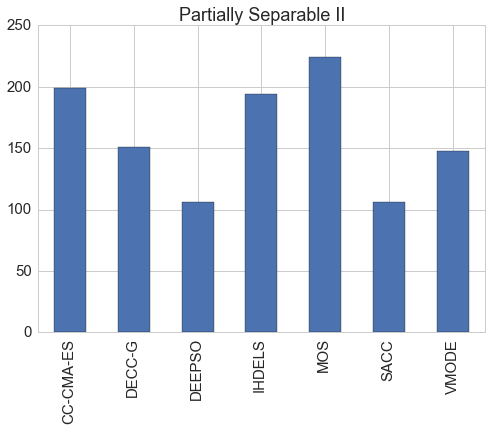

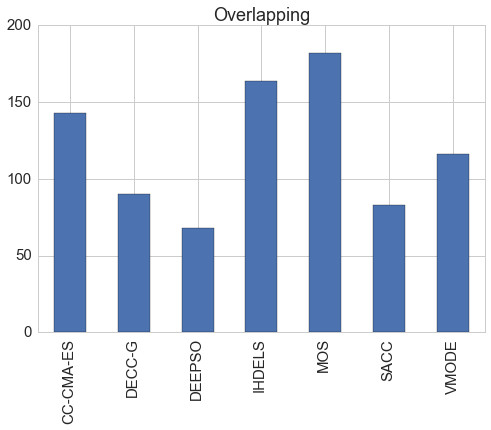

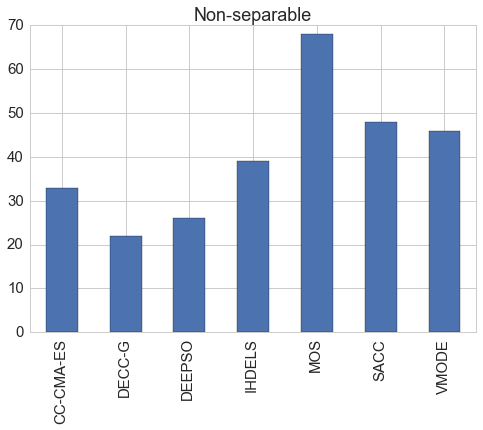

In [16]:
for fid, funs in enumerate(funs_group):
    title = funs_group_names[fid]
    results = get_scores(df, algs, funs, accuracies)
    results_df = pd.Series(results)
    plt.figure()
    results_df.plot(kind='bar', title=title)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

Now, we are going to show for group for the Excel file.

In [17]:
funs_categories = dict(zip(funs_group_names, funs_group))
excel = pd.ExcelWriter("results.xls")

In [18]:
def print_results(df, algs, title, funs, accuracies, style='b'):
    results = get_scores(df, algs, funs, accuracies)
    results_df = pd.Series(results)
    plt.figure()
    pd.DataFrame(results_df, columns=['Results']).to_excel(excel, title)
    results_df.plot(kind='bar', title=title, color=style)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

#### By Groups

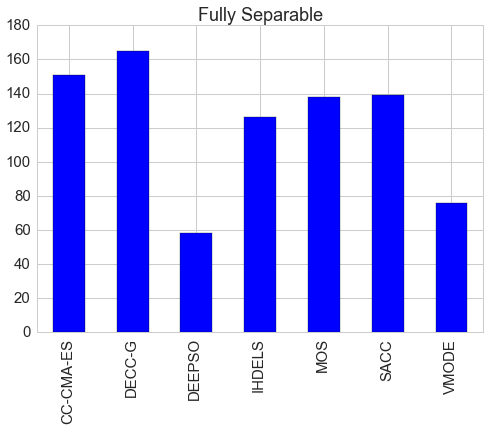

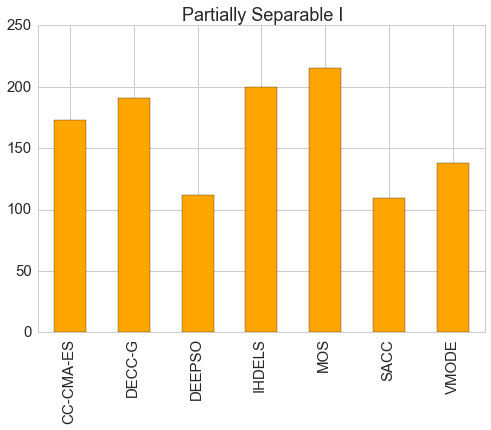

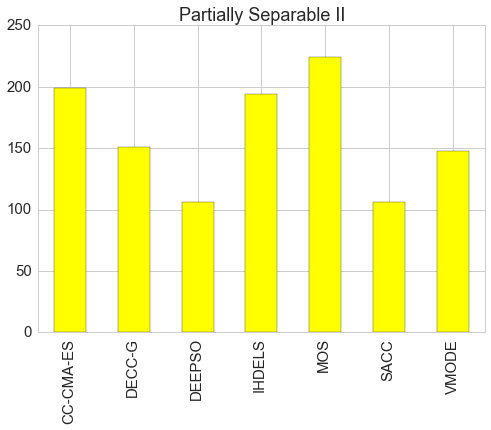

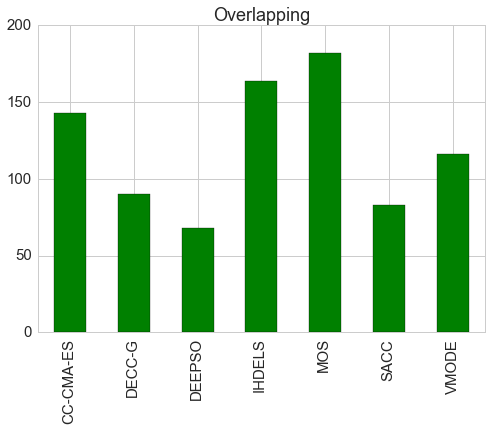

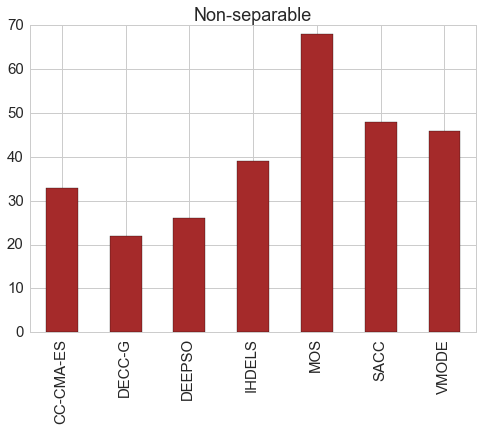

In [19]:
fig_names = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5']
styles = ['blue', 'orange', 'yellow', 'green', 'brown']

for id, title in enumerate(funs_group_names):
    fig_name = fig_names[id]
    print_results(df, algs, title, funs_categories[title], accuracies, styles[id])
    plt.savefig(fig_name, bbox_inches='tight')

### By Category

In [20]:
def results_by_accuracy(acc):
    styles = ['blue', 'orange', 'yellow', 'green', 'brown']
    funs = range(15)
    results_cat = pd.DataFrame(columns=funs_group_names)

    for id, fun in enumerate(funs_group_names):
        fig_name = 'fe{}'.format(acc)
        results = get_scores(df, algs, funs_categories[fun], [acc])
        results_cat[fun] = pd.Series(results)
 
    title = 'Results after {} Fitness Evaluations'.format(acc)
    results_cat.plot(kind='bar', title=title, stacked=True)
    results_cat.to_excel(excel, acc)
    

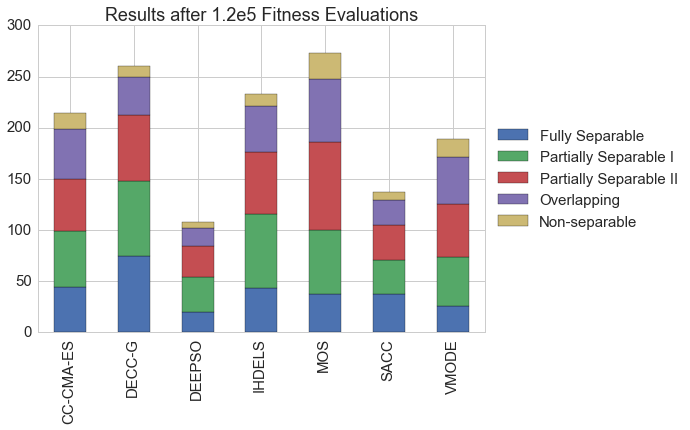

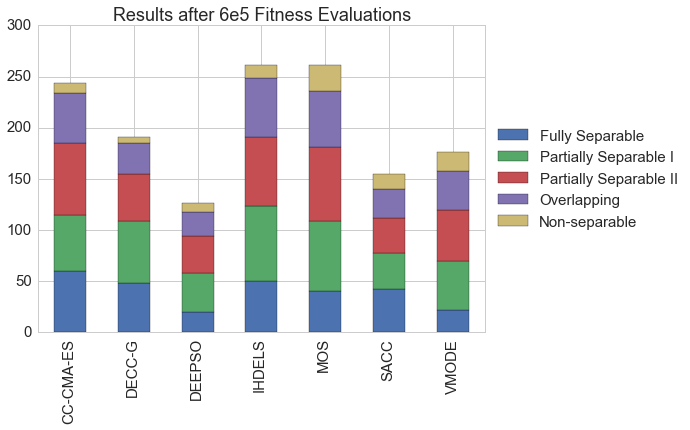

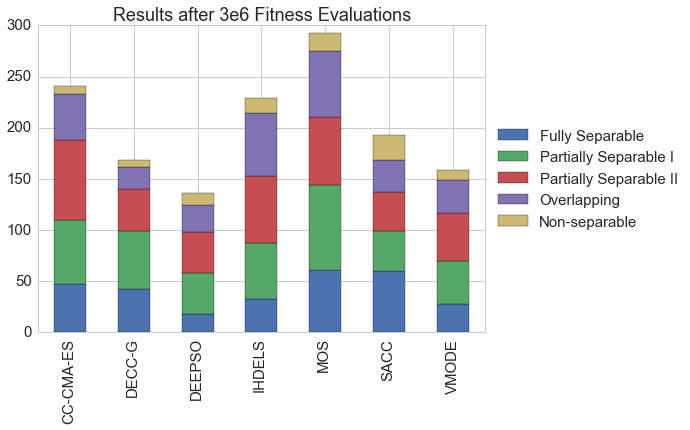

In [21]:
for acc in accuracies:
    plt.figure()
    results_by_accuracy(acc)
    fname = '{}.png'.format(acc.replace('.',''))
    lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [22]:
def results_by_all():
    styles = ['blue', 'orange', 'yellow', 'green', 'brown']
    funs = range(15)
    results_cat = pd.DataFrame(columns=funs_group_names)

    for id, fun in enumerate(funs_group_names):
        fig_name = 'fall'
        results = get_scores(df, algs, funs_categories[fun], accuracies)
        results_cat[fun] = pd.Series(results)
 
    title = 'Overall score'
    results_cat.plot(kind='bar', title=title, stacked=True)
    results_cat.to_excel(excel, 'all')
    

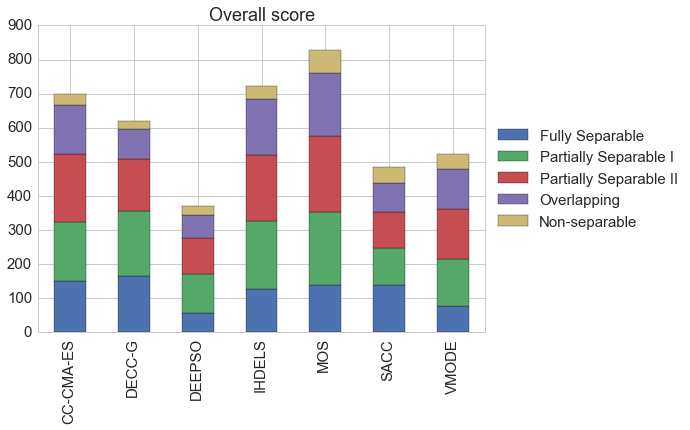

In [23]:
plt.figure()
results_by_all()
fname = 'all.png'
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
excel.save()